In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

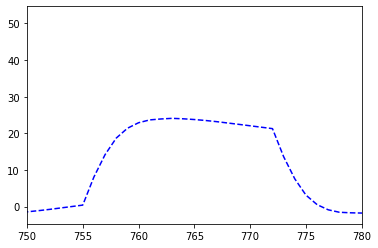

In [2]:
# GET OBSERVATIONS
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
OBSERVATIONS_LIST = []
OBSERVATIONS_LIST_2 = []
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)
    
    
# for i, precip in enumerate(df_forcing['APCP_surface_NoObsEnd']): #i is RAINRATE
#     cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
#     cfe_obs.update()
#     OBSERVATIONS_LIST_2.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)   
   
#OBSERVATIONS_LIST_2 = OBSERVATIONS_LIST[0:769] # getting observations for EnKF without 18hour forecast

cfe_obs.finalize()
plt.plot(OBSERVATIONS_LIST_2,color = 'green',)
plt.plot(OBSERVATIONS_LIST,color = 'blue', linestyle='dashed')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
# Initialize Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


In [5]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)

<module 'bmi_cfe_open' from '/home/jovyan/data/project/Working_DA/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from '/home/jovyan/data/project/Working_DA/NextGen---The-Simulators-/Toy_Model/./CFE/bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from '/home/jovyan/data/project/Working_DA/NextGen---The-Simulators-/Toy_Model/./Assimilation/Bmi_da_ENKF_forSBMI.py'>


In [6]:
# with open(cfe_open.forcing_file, 'r') as f:
#     df_forcing = pd.read_csv(f)
    
# print(df_forcing)
#plt.plot(df_forcing['APCP_surface'])

#values = df_forcing['APCP_surface']
#print(values)

In [7]:
#Make empty matrices for plotting
# cfeOpen = []
# cfePeturbed = []
# cfeAnalysis = []
# cfeEnKF = []

n_loop = 3
cfeOpen_ensa=[]
cfeAnalysis_ens=[]
## Loop through 100 different precipitation files for forcing 
for loop in range(n_loop):
    p = 'APCP_surface_' + str(loop)
    print(p)
    cfeOpen = []
    cfePeturbed = []
    cfeAnalysis = []
    cfeEnKF = []
    # Initialize Case study files
    cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
    enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still
    ## Loop through time. Set values for each model and get values
    for i, precip in enumerate(df_forcing[str(p)]): #i is RAINRATE

        # Set values for each model
        cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
        cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
        cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)

        obs = OBSERVATIONS_LIST[i]
        enkf.set_value('validity', 1)

        if i>769:
            enkf.set_value('validity', 0)

        # Update CFE open and peturbed. Get value for peturbed stats. 
        cfe_open.update()
        cfe_peturbed.update()

        # Get state vars from Peturbed. These are values as enkf uses
        soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
        soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
        surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

        # Get values for plotting
        outflow = cfe_open.get_value('land_surface_water__runoff_depth')
        cfeOpen.append(outflow) #for plotting
        outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')

        # Get mean and covariance for stats of ensemble runs for EnKF
        outflow_peturb_mean = np.mean(outflow_peturb)
        outflow_peturb_covar = np.cov(outflow_peturb)
        cfePeturbed.append(outflow_peturb_mean) # For plotting

        # Set EnKF value to usgs, mean, and covariance. Get value from it then update
        enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
        enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
        enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf

        enkf.set_value('x', np.array([outflow_peturb_mean]))
        enkf.set_value('P', np.array([outflow_peturb_covar]))
        enkf.set_value('z', np.array([obs]))
        enkf.update()

        # For plotting
        outflow_enkf = enkf.get_value('enkf')
        cfeEnKF.append(outflow_enkf)

        # Get new EnKF state vars to give back to CFE Analysis
        state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
        state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
        state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

        # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
        cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
        cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
        cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
        cfe_analysis.update() #get new streamflow value based on state var change

        # For plotting
        outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
        cfeAnalysis.append(outflow_analysis) 

        # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
        cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
        cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
        cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

        # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
        cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
        cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
        cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
    # predicted values
    cfeOpen_error=cfe_open#.subtract(OBSERVATIONS_LIST[769:])
    cfeAnalysis_error=cfeAnalysis#[769:]#.subtract(OBSERVATIONS_LIST[769:])
    cfeOpen_ensa.append(np.array(cfeOpen))
   
    mean=np.mean(cfeOpen_ensa)
    print("mean.shape",mean)
    cfeOpen_ensa.to_csv(" CFEopen.csv")    
#[[],[],[]]
    # print(cfeOpen_ensa)
    # Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()



APCP_surface_0
initialized 10
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.60253793]
surface_runoff_ratio [0.57761199]
Leftover vol [26.33416556]
surface _runoff [0.57761199]
***********over estimaiton ratio [0.26720698]
Observation BMI [9.14803171]
CFE [35.93670349]
enkf [9.60253793]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [17.35241943]
surface_runoff_ratio [2.28075293]
Leftover vol 0.0
surface _runoff [2.28075293]
***********over estimaiton ratio [1.]
Observation BMI [16.75252741]
CFE [33.03673102]
enkf [17.35241943]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.373038]
surface_runoff_ratio [1.81753582]
Leftover vol [25.15917667]
surface _runoff [1.81753582]
***********over estimaiton ratio [0.4706921]
Observation BMI [22.40183725]
C

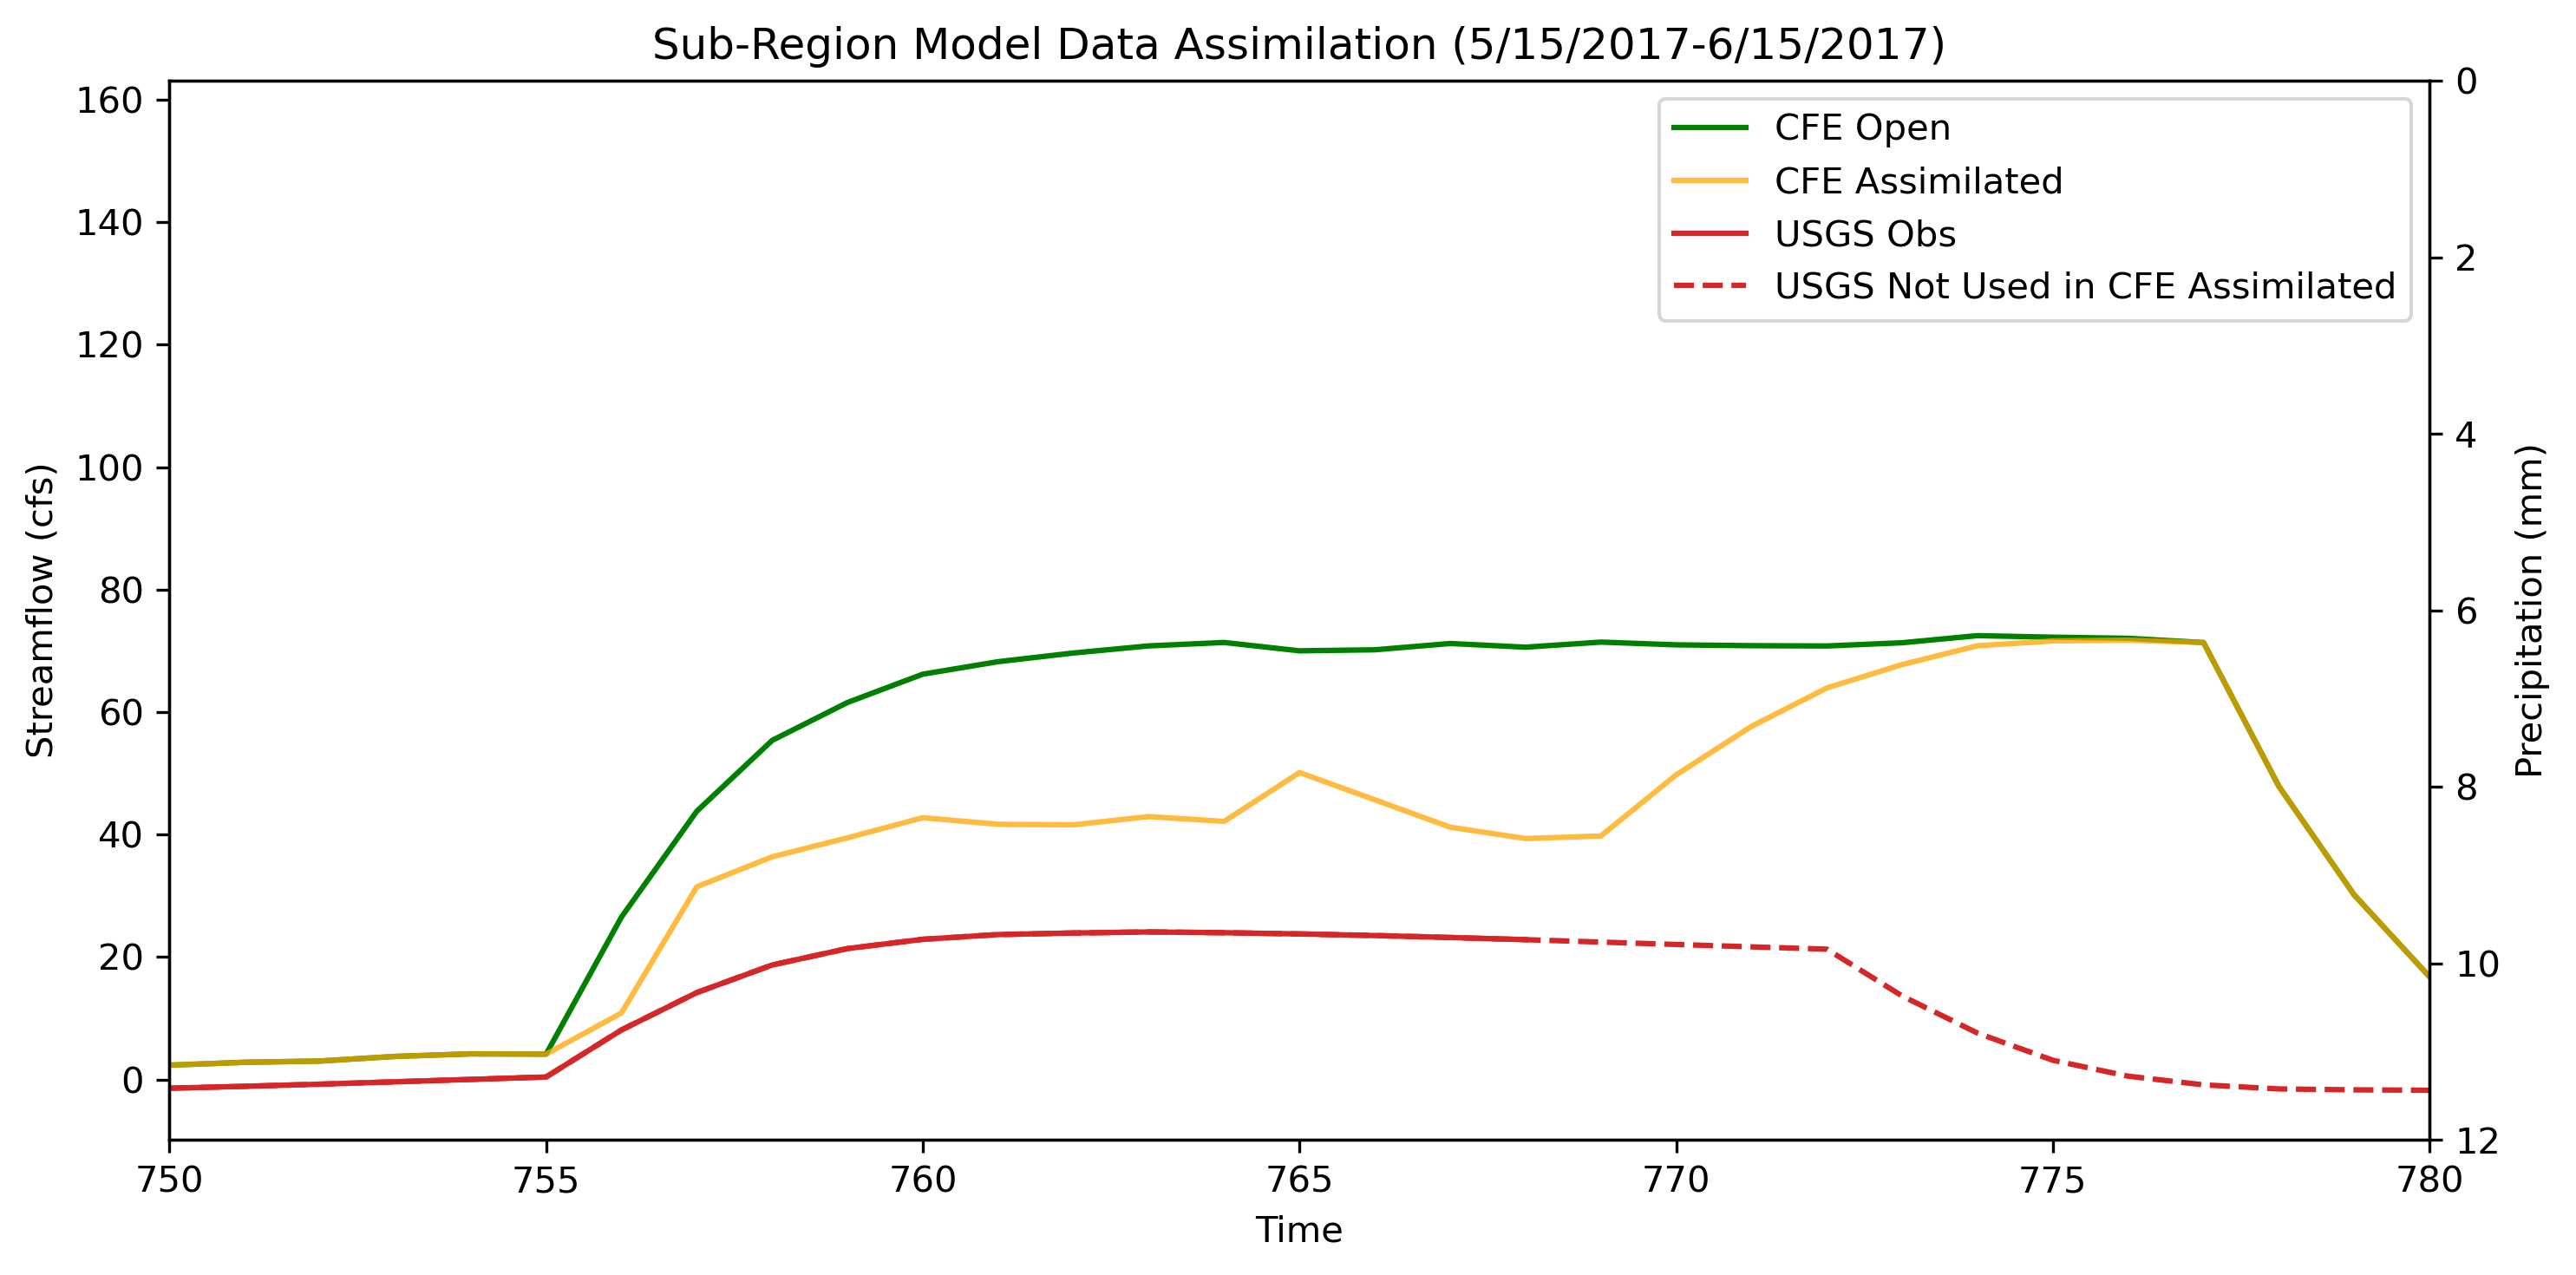

In [8]:
istart_plot=0
istart_plot_2=769
iend_plot=786
x = list(range(istart_plot, iend_plot))

Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,50,1)
plt.xlim(750,780)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
#Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:769], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Not Used in CFE Assimilated')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
#ax1.tick_params(axis='x', labelrotation = 45)

plt.legend(handles = [Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [9]:
OBSERVATIONS_LIST[769:]
cfeAnalysis[769:]
cfeOpen[769:]


[71.43064674004256,
 70.981468849024,
 70.84677861243424,
 70.79715672438758,
 71.32450279909973,
 72.48671750863598,
 72.23310977696936,
 72.04985969503325,
 71.35748776214287,
 47.87833697387144,
 30.14205414447994,
 16.781692000614257,
 10.205141494656326,
 6.0602321835509265,
 4.086450575890274,
 4.19902088570048,
 2.7388023698775754]

In [10]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

In [11]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9811133952155429
KGE_open= 0.019911120928488457
NSE_open= 0.20921677044788978
PBias= 72.46925854901218
r_analysis= 0.9484279958862674
KGE_analysis= 0.28318565478400815
NSE_analysis= 0.5037997261342755
PBias= 57.40573206896909
mean_obs= 7.364020014124947
STD_obs= 11.269336969020186
mean_open= 26.748353389736693
STD_open= 33.10365409842358
mean_analysis= 17.28875825744639
STD_analysis= 19.638825979340318
